In [ ]:
!pip install pygsp

In [ ]:
from sklearn.covariance import GraphicalLasso as glasso
import numpy as np
import shlex
import networkx
import timeit
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np 
import matplotlib.pyplot as plt 
from time import time 
import timeit
import networkx as nx
import pygsp
from sklearn import preprocessing
from scipy.optimize import linprog
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import normalized_mutual_info_score as nmi
import cvxpy as cp
from scipy.optimize import bisect
from scipy import sparse
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pickle
def save_variable(variable,filename):
  pickle.dump(variable,open(filename, "wb"))
def load_variable(filename):
  return pickle.load(open(filename,'rb')) 
def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap  

In [ ]:
def UpdateW(X,c,beta1,beta2,max_iter,rho_w,w_init):
  w = w_init
  N = len(X[:,0])
  D = len(X[0,:])
  c.shape = (N,1)
  w.shape = (D,2)
  B1 = X.T@np.append(c,np.ones((N,1)),1)
  B2 = np.append(c,np.ones((N,1)),1).T@np.append(c,np.ones((N,1)),1)
  for j in range(max_iter):
    w = w + rho_w*((B1-w@B2)-beta1*w)  
    if (sum(sum(abs(((B1-w@B2)-beta1*w)<1.0e-4*np.ones((len(X[0,:]),1)))))==2*len(X[0,:])):
      print('w Converged!')
      break   
  return w

def UpdateC(X,w,abstheta,rho_c,c_init,max_iter,m,beta1):
  c = c_init
  N = len(X[:,0])
  D = len(X[0,:])
  c.shape = (N,1)
  w.shape = (D,2)
  obj=[]
  c.shape = (N,1)
  w_ = w[:,0]
  w_.shape = (D,1)
  A1 = X@w_+(abstheta@np.ones((N,1)))
  A2 = w.T@w_
  for j in range(max_iter):
    c = c + rho_c*(A1-np.append(c,np.ones((N,1)),1)@A2)

    def f(x):
      return sum([min(max(c[k]-x,0),1) for k in range(N)])-m   
    lamda =  bisect(f,-1000000,1000000) 
    for i in        range(N):
      c[i] = min(max(c[i]-lamda,0),1) 
    obj.append(sum(abs(A0)@c)-np.linalg.norm(X-np.append(c,np.ones((N,1)),1)@w.T)**2)
    if j>1:
      if (abs(obj[j]-obj[j-1])<1.0e-4): 
        print('c Converged')
        break  
  return c

In [ ]:
# Loading data - C.elegans
data = loadmat('/Datasets/Celegans.mat')
A0=np.array(data['A0'].todense())
N=len(A0[:,0])
coords = data['coords']
X = data['coords']


'''
To load the other datasets used in the paper:

# London underground
data = loadmat('/Datasets/London_underground.mat')
A0=np.array(data['A0'])
N=len(A0[:,0])
coords = data['Coords']
X = data['Coords']


# Freeman
#attribute 1
f = open('/Datasets/Freemans_EIES/citations.txt')
Lines = f.readlines()
citations_ = []
for line in Lines:
   citations_.append(line.split(" "))
citations = np.zeros((len(citations_[0]),1))   
for i in range(len(citations)):
  citations[i,0] = int(citations_[0][i])   
f.close()
#attribute 2
f = open('/Datasets/Freemans_EIES/code_for_area_of_res.txt')
Lines = f.readlines()
code_ = []
for line in Lines:
   code_.append(line.split(" "))
code = np.zeros((len(code_[0]),1))   
for i in range(len(code)):
  code[i,0] = int(code_[0][i])   
f.close()
N = len(code)
#G1
#The other 2 graphs in this dataset do not have node attributes
f = open('/Datasets/Freemans_EIES/g3.txt')
Lines = f.readlines()
edges = []
for line in Lines:
   edges.append(line.split(" "))
f.close()
A_=np.zeros(np.shape(edges))
for i in range(len(edges)):
  for j in range(len(edges[0])):
    A_[i,j] = int(edges[i][j])-1

A0 = sparse.csr_matrix((A_[:,2], (A_[:,0], A_[:,1])), shape=(N, N)).toarray()
X = np.append(NormalizeData(citations),NormalizeData(code),axis=1)
    

# Cross_parker_consultation
#attribute 1
f = open('/Datasets/cross_parker_consulting_info/gender.txt')
Lines = f.readlines()
gender_ = []
for line in Lines:
   gender_.append(line.split(" "))
gender = np.zeros((len(gender_[0]),1))   
for i in range(len(gender)-1):
  gender[i,0] = int(gender_[0][i])   
f.close()
#attribute 2
f = open('/Datasets/cross_parker_consulting_info/2/location.txt')
Lines = f.readlines()
location_ = []
for line in Lines:
   location_.append(line.split(" "))
location = np.zeros((len(location_[0]),1))   
for i in range(len(location)-1):
  location[i,0] = int(location_[0][i])   
f.close()
#attribute 3
f = open('/Datasets/cross_parker_consulting_info/2/orglevel.txt')
Lines = f.readlines()
level_ = []
for line in Lines:
   level_.append(line.split(" "))
level = np.zeros((len(level_[0]),1))   
for i in range(len(level)-1):
  level[i,0] = int(level_[0][i])   
f.close()
#attribute 4
f = open('/Datasets/cross_parker_consulting_info/2/tenure.txt')
Lines = f.readlines()
region_ = []
for line in Lines:
   region_.append(line.split(" "))
region = np.zeros((len(region_[0]),1))   
for i in range(len(region)-1):
  region[i,0] = int(region_[0][i])   
f.close()
N = len(location)
#G1
#Only the graphs change
f = open('/Datasets/cross_parker_consulting_info/g3.txt')
Lines = f.readlines()
edges = []
for line in Lines:
   edges.append(line.split(" "))
f.close()
A_=np.zeros((len(edges),3))
for i in range(len(edges)):
  for j in range(len(edges[0])-1):
    A_[i,j] = int(edges[i][j+1])-1

A0 = sparse.csr_matrix((A_[:,2], (A_[:,0], A_[:,1])), shape=(N, N)).toarray()
n2del = [77,73,66,65,64,61,60,59,53,47]#nodes to be deleted for g3, g4
#n2del = [46]#nodes to be deleted for g1, g2
for i in range(10): #10 for g3,g4
  A0 = np.delete(A0,n2del[i],0)
  A0 = np.delete(A0,n2del[i],1)
X = np.zeros((N,3))
#X[:,0:1] = NormalizeData(gender)
X[:,0:1] = NormalizeData(location)
X[:,1:2] = NormalizeData(level)
X[:,2:3] = NormalizeData(region)
X=X.T
for i in range(10):#10 for g3,g4
  X = np.delete(X,n2del[i],1)
#X = np.ones((N,2))
N=len(A0[:,0])
 

# Openflights
data = loadmat('/Datasets/openflights/openflights_final_.mat')
A0 = np.array(data['A0'].todense())
N = len(A0[:,0])
X_ = data['X_airports_'][:,3:]
X = np.append(X_,A0@np.ones((N,1)),axis=1)
N=len(A0[:,0])
D = load_variable('/Datasets/openflights/D_great_circle')


# Olympics
data = loadmat('/Datasets/olympics.mat')
X = data['X2']
A0 = data['X3']+data['X4']
N=len(A0[:,0])

# Synthetic data
A0 = load_variable('/Datasets/syn/theta_syn')
N = np.size(A0,0)
X = load_variable('/Datasets/syn/X_ao')
D = np.size(X,1)  
c_true = load_variable('/Datasets/syn/c_syn')   
'''

In [ ]:
C= np.zeros((N,1))
beta1 = 1
beta2 = 1
max_iter = 4
obj_fn = []
w = 0.1*np.ones((len(X[0,:]),2))
c = 0.1*np.ones((N,))
for m in range (0,max_iter):   
#Update c---------------------------------------------------------------------
    c = UpdateC(X,w,abs(A0),1e-3,c,10**2,N/4,beta1=1) 


#Update w---------------------------------------------------------------------
    w = UpdateW(X,c,beta1,beta2,10**3,1e-4*np.ones((len(X[0,:]),1)),w) #X,Q,c,beta,max_iter,rho_w,w_init

    obj_fn.append(sum(abs(A0)@c)-np.linalg.norm(X-np.append(c,np.ones((N,1)),1)@w.T)**2-beta2*np.linalg.norm(w)**2)
    print("c=",c.T)

############--------------------------------------------------------------------
    if (m>0):
      if (abs(obj_fn[m]-obj_fn[m-1])<10**(-4)):
       #if (np.linalg.norm(C-C_)<10**(-7)):
        break

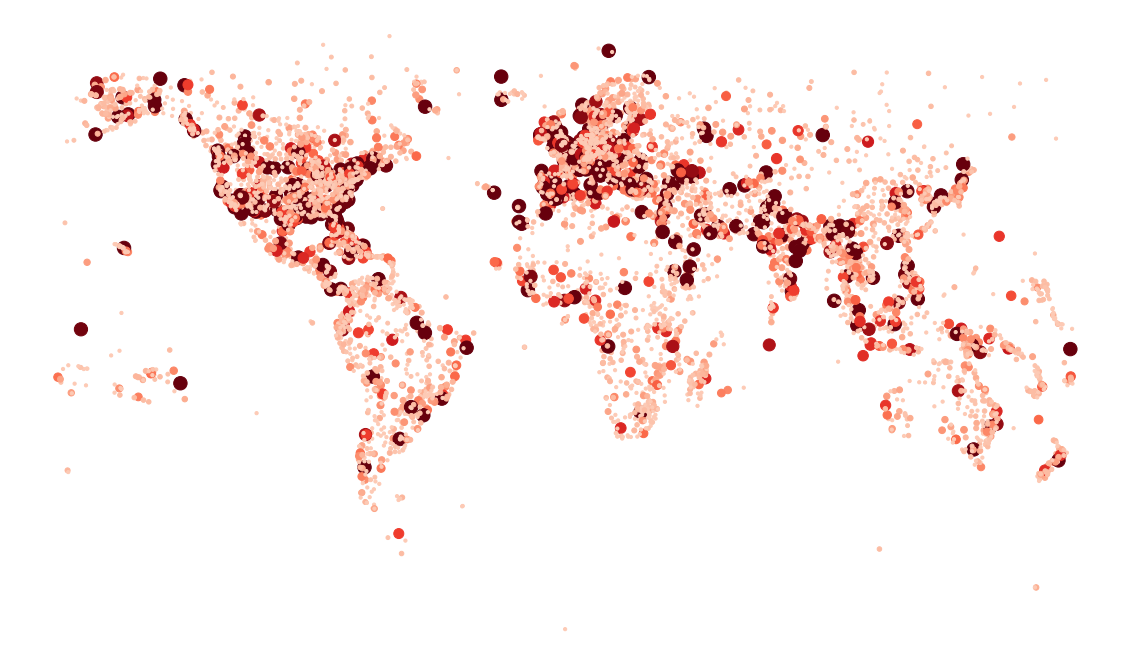

In [ ]:
X_ = data['X_airports_']
A0[A0<5]=0
G = nx.convert_matrix.from_numpy_matrix(A0)
coords = np.append(X_[:,1:2],X_[:,0:1],axis=1)
pos = dict(enumerate(coords))
fig, axes = plt.subplots(1, 1, figsize=(20, 12))
cmap=plt.get_cmap('Reds')
new_cmap = truncate_colormap(cmap, 0.2, 1)
p=nx.draw(G, pos=pos,cmap=new_cmap, node_color=(c),node_size=180*((c+0.001)),ax=axes,alpha=1,edge_color='lightsteelblue')
#plt.show()
plt.savefig('airports.pdf')
plt.show(block=False)